In [1]:
import numpy as np
from scipy.io import loadmat
from h5py import File
from multiprocessing import Pool
from functools import partial
from skimage.exposure import rescale_intensity
import matplotlib.pyplot as plt

In [2]:
def get_mika_timeseries(path, roi=None, key='T'):
    '''
    Load data from Cells0_clust.mat as a numpy array.
    '''
    from h5py import File
    with File(path) as f:
        if roi is not None:
            ts = f[key][roi]
        else:
            ts = f[key].value
    return ts

def clean_coord(coord):
    return [c[~np.isnan(c)].astype('int') for c in coord]

def get_mika_coords(path):
    '''
    Load zyx coordinates for superpixels from Cells0_clean.mat, 
    Return coords as a list of tuples along with dims of bounding box of all superpixels
    '''
    from h5py import File
    with File(path) as f:
        coords = (f['Cell_Z'][:].T - 1, f['Cell_Y'][:].T - 1, f['Cell_X'][:].T - 1)
    
    dims = [int(np.nanmax(c)) + 1 for c in coords]
    cleaned = list(zip(*[clean_coord(coord) for coord in coords]))
    return cleaned, dims

# reconstruct a volume for each timepoint
def reconstruct_vol(timepoint, coords, dims, ds_xy = 1, fill_value=0, dtype='float32'):
    from numpy import zeros, array
    vol = zeros(dims, dtype=dtype) + fill_value;
    for ind,spx in enumerate(timepoint):
        coord_array = array([coords[ind][0], coords[ind][1], coords[ind][2]])
        vol[coord_array[0], coord_array[1], coord_array[2]]= spx
    return vol[:,::ds_xy, ::ds_xy]

In [3]:
base_dir = '/groups/ahrens/ahrenslab/mika/yu/data/glia/20161022_1_1_cy221_6dpf_GA_0gain_20161022_151003/' 
exp_name = base_dir.split('/')[-2]

In [4]:
with File(base_dir + 'ephys/data.mat') as f:
    epdat = {k: np.squeeze(f['data'][k]) for k in f['data'].keys()}
# there are some dodgy values in here, where the time between giving up is like 5s...
gu_onsets = loadmat(base_dir + 'ephys/GU_onset.mat', squeeze_me=True)['GU_onset']

In [5]:
window = np.arange(-20,20)
gu_frames = [epdat['frame'][guo] for guo in gu_onsets]
gu_frames = list(filter(lambda v: (v+window).max() < epdat['frame'].max(), gu_frames))
gu_frames = np.array(gu_frames).astype('int')
gu_frames = gu_frames[1:][np.diff(gu_frames) > len(window)]
windowed_gu = (gu_frames.reshape(-1,1) + window)

In [6]:
%%time
from glob import glob
import nibabel as nib

ts_raw = get_mika_timeseries(base_dir + '/ana/Cells0_clust.mat', key='Cell_timesers1').astype('float32')
coords,_ = get_mika_coords(base_dir + 'ana/Cells0_clean.mat')
mask_fnames = sorted(glob(base_dir + 'ana/binary_masks0/weighted*.nii.gz'))
masks= np.array([nib.load(mf).get_data().T for mf in mask_fnames])
dims = masks[0].shape

CPU times: user 1min 16s, sys: 5.98 s, total: 1min 22s
Wall time: 1min 25s


In [171]:
cell_id = np.arange(ts_raw.shape[1])
cell_id_vol = reconstruct_vol(cell_id, coords, dims).astype('int')
brain_mask = cell_id_vol > 0

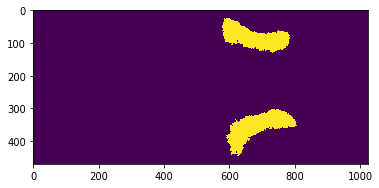

In [8]:
# manually specify the waist
#%matplotlib inline
#z = 20
#fig, axs = plt.subplots(ncols=2)
#axs[0].imshow(cell_id_vol[z])
#roi_w = (slice(300, 450), slice(600, 800))
#axs[1].imshow(cell_id_vol[z][roi_w])

# get waist roi from mask
waist_mask = masks[8] > .5
plt.imshow(waist_mask.max(0))

In [9]:
coi = np.unique(cell_id_vol[waist_mask])
coi = coi[coi > 0]

In [10]:
%%time
from fish.image.vol import baseline
bl = baseline(ts_raw, window=100, percentile=10, downsample=4, axis=0).astype('float32')
bls = (ts_raw - bl).astype('float32')

CPU times: user 1min 19s, sys: 13.3 s, total: 1min 32s
Wall time: 1min 32s


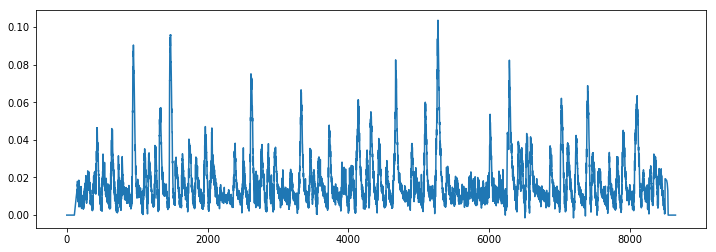

In [11]:
fig, axs = plt.subplots(figsize=(12,4))
axs.plot(bls[:,coi].mean(1))

In [12]:
target = slice(None)

In [13]:
seed = bls[:,coi].mean(1)

In [14]:
%%time
from scipy.stats import zscore

from scipy.signal import correlate
corr = correlate(zscore(bls[:][:,target], axis=0), zscore(seed[:].reshape(-1,1), axis=0), mode='same')
corr_pk = np.argmax(corr, axis=0) - corr.shape[0] // 2

CPU times: user 4min 28s, sys: 2min 4s, total: 6min 33s
Wall time: 7min


In [185]:
from scipy.signal import wiener

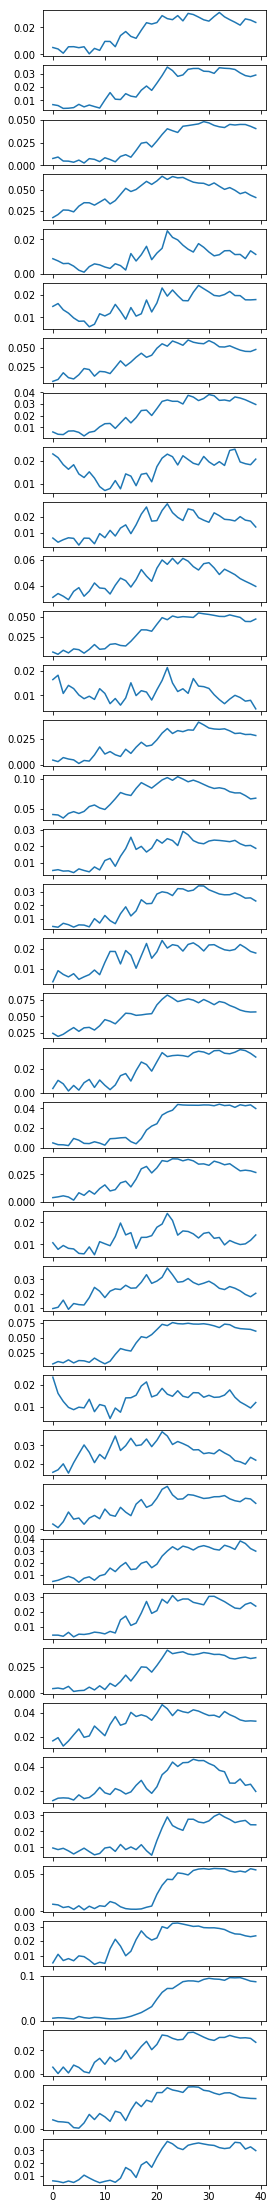

In [187]:
order = np.argsort(seed[windowed_gu].ptp(0))[::-1]
nr = len(order)
fig, axs = plt.subplots(nrows=nr, figsize=(4,1 * nr), sharex=True)
for ind, ax in enumerate(axs):
    ax.plot(seed[windowed_gu][order[ind]]);
    ax.plot(wiener(seed[windowed_gu][order[ind]]));

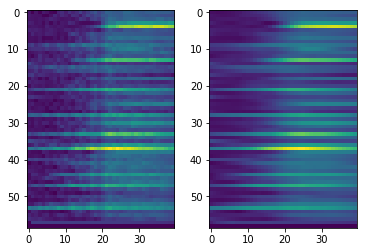

In [17]:
from scipy.signal import savgol_filter
fig, axs=plt.subplots(ncols = 2)
axs[0].imshow(seed[windowed_gu]);
axs[1].imshow(savgol_filter(seed[windowed_gu], window_length=13, polyorder=2, axis=1));

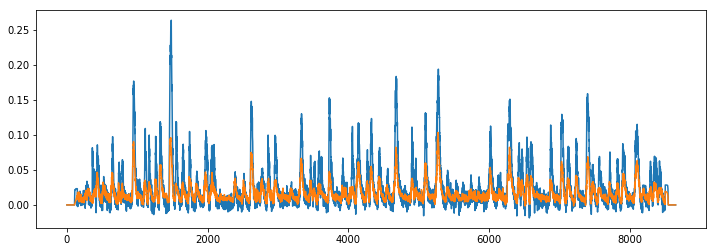

In [18]:
fig, axs = plt.subplots(figsize=(12,4))
axs.plot(bls[:,np.argmax(corr.max(0))])
axs.plot(seed)

In [165]:
from matplotlib import cm
from skimage.exposure import rescale_intensity
clim = (-6,6)
v_mag = reconstruct_vol(rescale_intensity(corr.max(0), out_range=(0,1)), np.array(coords)[target], dims=dims, fill_value=0)
v_pk = reconstruct_vol(corr_pk, np.array(coords)[target], dims=dims, fill_value=0)
v_c = cm.bwr(rescale_intensity(v_pk.clip(*clim), out_range=(0,1)))
v_c[:,:,:,:-1] *= v_mag.reshape(*v_mag.shape, 1)

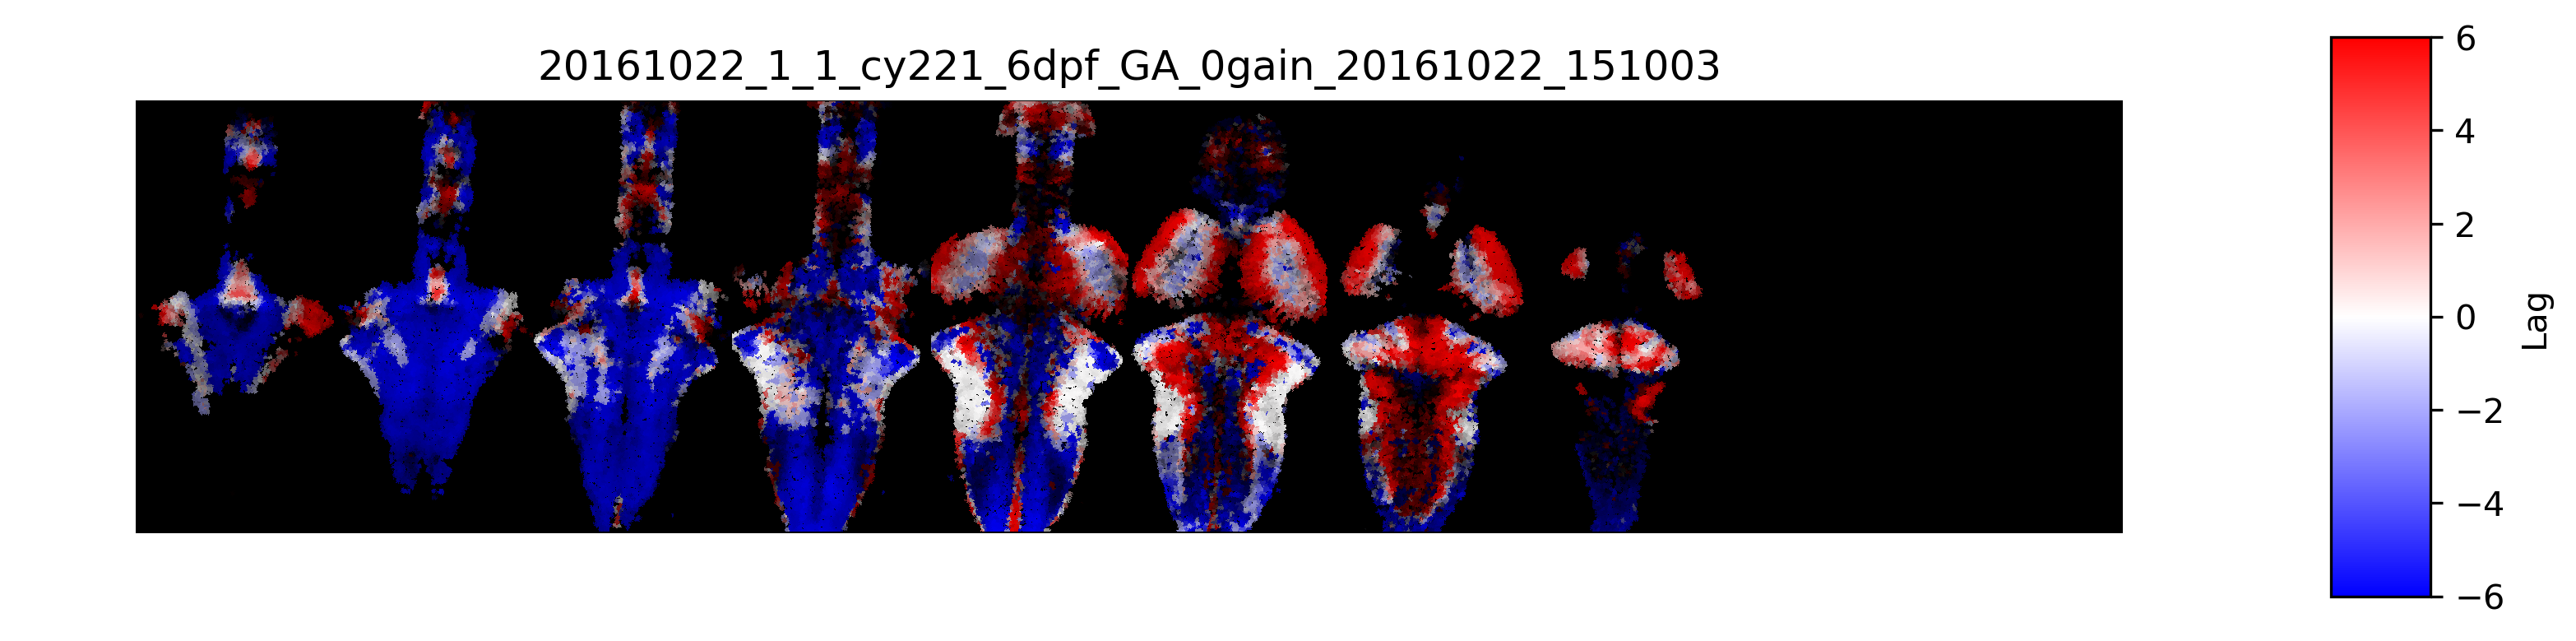

In [166]:
import matplotlib as mpl
fig, axs = plt.subplots(figsize=(12,3), dpi=300, ncols=2, gridspec_kw={'width_ratios' : (20,1)})
to_plot = v_c[::4]
axs[0].title.set_text(exp_name)
axs[0].imshow(to_plot.reshape(to_plot.shape[0] * to_plot.shape[1], *to_plot.shape[2:]).transpose(1,0,-1))
axs[0].axis('off')
cmap = cm.bwr
norm = mpl.colors.Normalize(*clim)

cb1 = mpl.colorbar.ColorbarBase(axs[-1], cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('Lag')


## Try method using mean peak time within giving up window

In [140]:
medpk = np.median(np.argmax(bls[windowed_gu], axis=1), axis=0) - len(window)//2
conf = 1/np.std(np.argmax(bls[windowed_gu], axis=1), axis=0)

In [183]:
from matplotlib import cm
from skimage.exposure import rescale_intensity
clim = (-10,10)
v_mag = reconstruct_vol(rescale_intensity(conf, out_range=(0,1)), np.array(coords)[target], dims=dims, fill_value=0)
v_pk = reconstruct_vol(medpk, np.array(coords)[target], dims=dims, fill_value=0)
v_c = cm.seismic(rescale_intensity(v_pk.clip(*clim), out_range=(0,1)))
v_c[~brain_mask] = np.NaN
#v_c[:,:,:,:-1] *= v_mag.reshape(*v_mag.shape, 1)

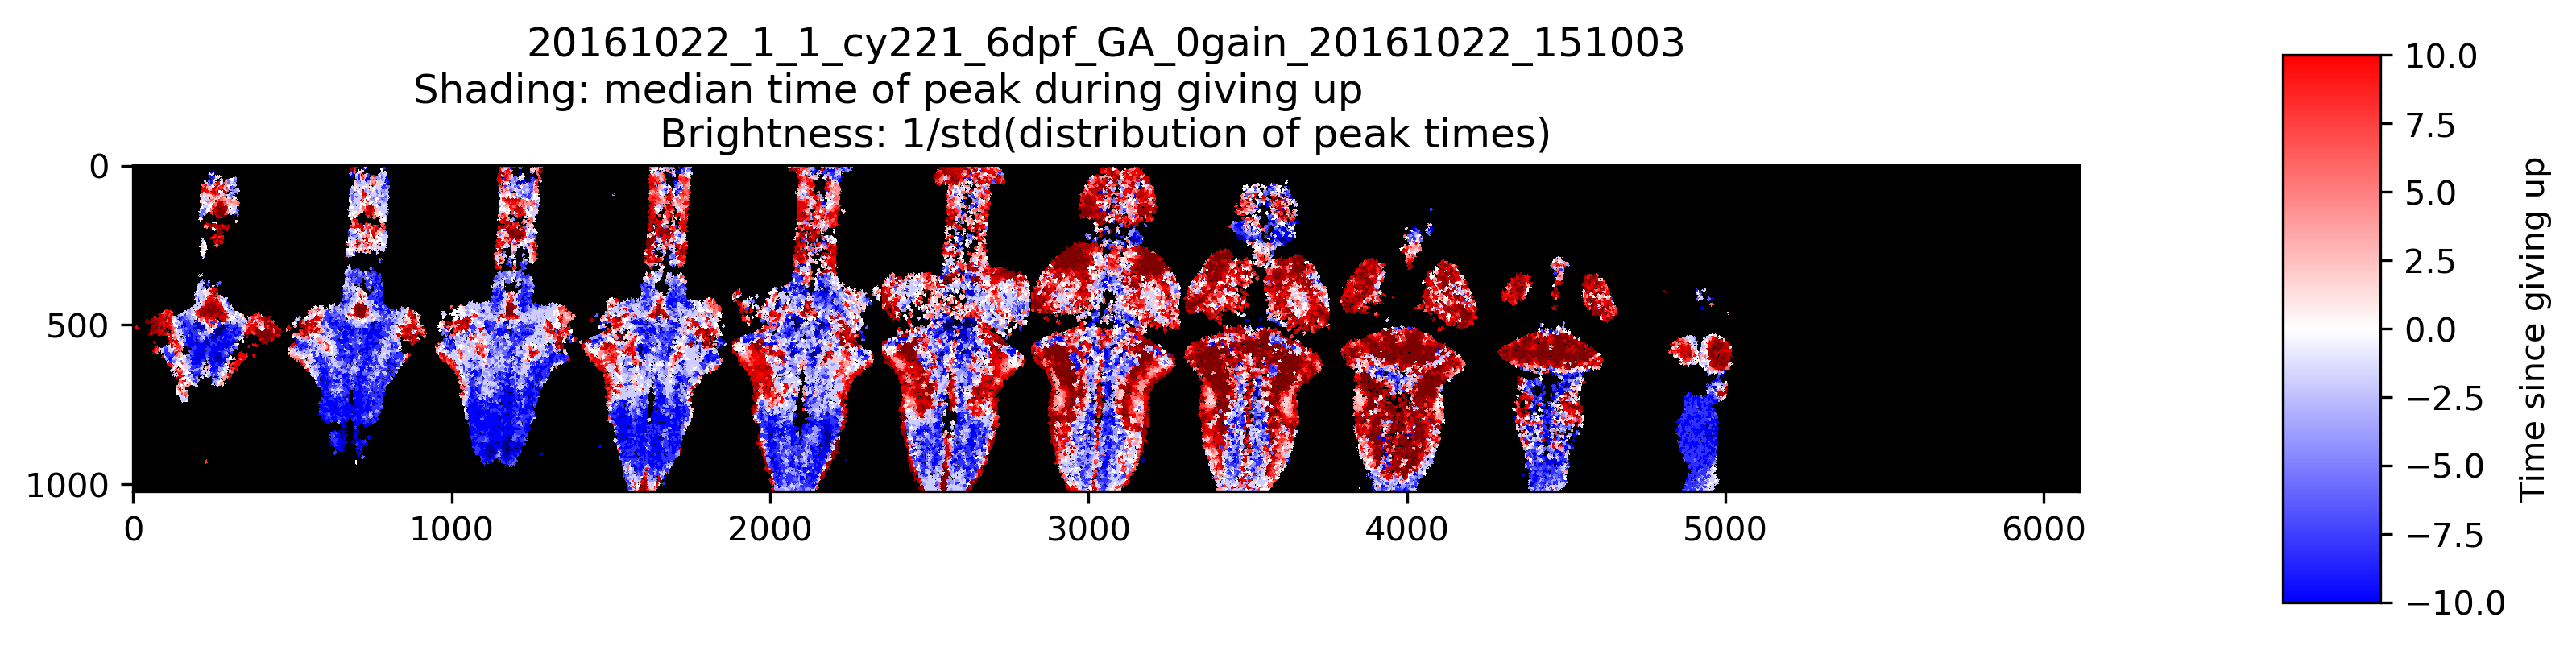

In [184]:
import matplotlib as mpl
fig, axs = plt.subplots(figsize=(12,3), dpi=300, ncols=2, gridspec_kw={'width_ratios' : (20,1)})
to_plot = v_c[::3]

axs[0].title.set_text(exp_name + '\nShading: median time of peak during giving up\
                                  \nBrightness: 1/std(distribution of peak times)')
axs[0].set_facecolor('k')
axs[0].imshow(to_plot.reshape(to_plot.shape[0] * to_plot.shape[1], *to_plot.shape[2:]).transpose(1,0,-1))
cmap = cm.bwr
norm = mpl.colors.Normalize(*clim)

cb1 = mpl.colorbar.ColorbarBase(axs[-1], cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('Time since giving up')